In [1]:
from netCDF4 import Dataset
from matplotlib import pyplot as plt, animation
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Proj
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import matplotlib
import xarray as xr

import scipy.sparse as sps

#import cartopy.crs as ccrs
#import cartopy.io.img_tiles as cimgt
#import cartopy.feature as cfeature
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#D:\NAMC\Data\Simulations\UK\2020\01\output\pylag_1.nc

In [2]:
# load the last year for the data

sim_jim=xr.open_mfdataset('Data/Simulations/UK/2017/03/output/pylag_1.nc').isel(time = slice(-366,-1))
sim_jim

<xarray.Dataset>
Dimensions:                   (time: 365, particles: 41600)
Coordinates:
  * time                      (time) datetime64[ns] 2020-01-02T12:00:00 ... 2...
Dimensions without coordinates: particles
Data variables:
    group_id                  (particles) int32 dask.array<chunksize=(41600,), meta=np.ndarray>
    longitude                 (time, particles) float32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    latitude                  (time, particles) float32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    depth                     (time, particles) float32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    host_arakawa_a            (time, particles) int32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    host_atmosphere           (time, particles) int32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    error_status              (time, particles) int32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    in_domain                 (time, particles) int32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    is_beached                (time, particles) int32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    land_boundary_encounters  (time, particles) int32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
Attributes:
    title:    PyLag -- Plymouth Marine Laboratory

In [3]:
#Calculate if the particles are in the region D, provided by the lon_range andt_range
lon_range = (3.5,6)  # Longitude range
lat_range = (59.6,61.2)  # latitude range

in_range =  sim_jim.\
where(sim_jim.latitude.compute() > lat_range[0]).\
where(sim_jim.latitude.compute() < lat_range[1]). \
where(sim_jim.longitude.compute() > lon_range[0]). \
where(sim_jim.longitude.compute() < lon_range[1])
in_range


<xarray.Dataset>
Dimensions:                   (particles: 41600, time: 365)
Coordinates:
  * time                      (time) datetime64[ns] 2020-01-02T12:00:00 ... 2...
Dimensions without coordinates: particles
Data variables:
    group_id                  (particles, time) float64 dask.array<chunksize=(41600, 365), meta=np.ndarray>
    longitude                 (time, particles) float32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    latitude                  (time, particles) float32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    depth                     (time, particles) float32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    host_arakawa_a            (time, particles) float64 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    host_atmosphere           (time, particles) float64 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    error_status              (time, particles) float64 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    in_domain                 (time, particles) float64 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    is_beached                (time, particles) float64 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    land_boundary_encounters  (time, particles) float64 dask.array<chunksize=(365, 41600), meta=np.ndarray>
Attributes:
    title:    PyLag -- Plymouth Marine Laboratory

In [4]:
# Using the [] operator, to extract only necessary variables
subset = in_range[['latitude', 'longitude']]
subset

<xarray.Dataset>
Dimensions:    (time: 365, particles: 41600)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-02T12:00:00 ... 2020-12-31T12:00:00
Dimensions without coordinates: particles
Data variables:
    latitude   (time, particles) float32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
    longitude  (time, particles) float32 dask.array<chunksize=(365, 41600), meta=np.ndarray>
Attributes:
    title:    PyLag -- Plymouth Marine Laboratory

In [5]:
#total particles 41600
#inD_counts = subset.isel(particles=slice(0,10000)).latitude.count(dim='time').values
inD_counts = subset.latitude.count(dim='time').values
num = (inD_counts > 0).sum() # number of particles that entered at least once; we can get their ID
#print(inD_counts)
print(f' out of 41600 partilces, {41600-num} have never entered and {num} have entered at least once')

 out of 41600 partilces, 39297 have never entered and 2303 have entered at least once


Number of particles that entered the region: 2303
Average number of time spent in D, per particle: 4.422926617455492
Minimum number of time for a particle: 1
Maximum number of time for a particle: 75


Text(0, 0.5, 'number of particles')

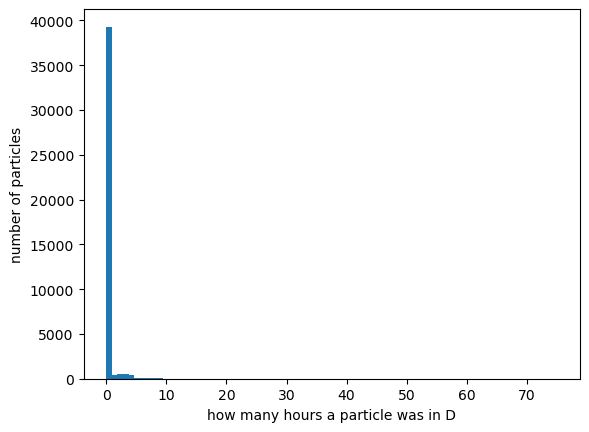

In [6]:
# Count the number of times each particle is in the region
# This should give me an array of how many times (days) the particle was within the subregion 
inD_counts = subset.latitude.count(dim='time')

# the number of particles that entered the region at least once

num = (inD_counts > 0).sum().values # number of particles that entered at least once;
inD_counts_np = inD_counts.values # making it a numpy array

# Some statistics
mean_entries = inD_counts_np[inD_counts_np > 0].mean()
min_entries = inD_counts_np[inD_counts_np > 0].min()
max_entries = inD_counts_np[inD_counts_np > 0].max()

print(f"Number of particles that entered the region: {num}")
print(f"Average number of time spent in D, per particle: {mean_entries}")
print(f"Minimum number of time for a particle: {min_entries}")
print(f"Maximum number of time for a particle: {max_entries}")

plt.hist(inD_counts_np,bins =80);
plt.xlabel('how many hours a particle was in D')
plt.ylabel('number of particles')


Text(0, 0.5, 'hours in D')

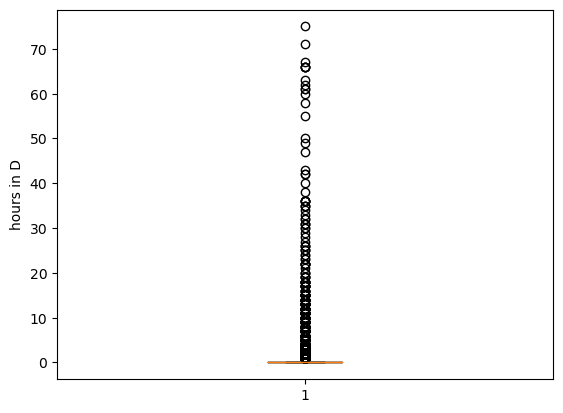

In [7]:
ax = plt.subplot()
ax.boxplot(inD_counts_np, showfliers=True);
ax.set_ylabel('hours in D')


In [8]:
lip = np.array(np.where(inD_counts_np>0)) # particle (that entered) ids 
lip=lip[0,:]
print(lip)
print(type(lip))
print(lip.shape)

[  103   104   111 ... 41588 41597 41598]
<class 'numpy.ndarray'>
(2303,)


particle Id is 126


Text(0.5, 0, 'lat')

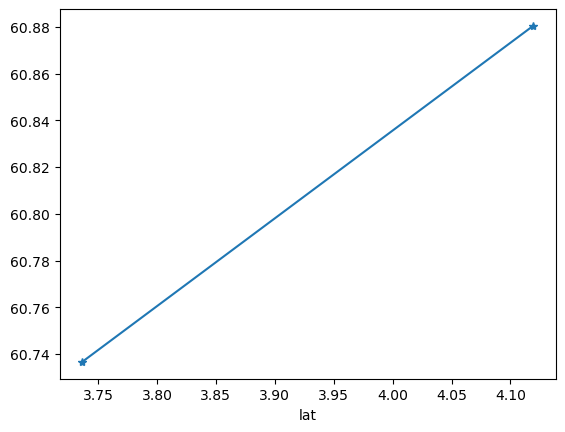

In [9]:
pid = lip[4]
print(f'particle Id is {pid}')
plt.plot(subset.longitude[:,pid],subset.latitude[:,pid],'-*')
plt.xlabel('lon')
plt.xlabel('lat')

In [ ]:
print(f'particle Id is {pid}')
subset.isel(particles=pid).longitude.plot.scatter()
inD_counts = subset.isel(particles=pid).latitude.count(dim='time').values
print(f'time in D is equal to {inD_counts}')

In [ ]:
#and the same with lat
subset.isel(particles=pid).latitude.plot.scatter()
inD_counts = subset.isel(particles=pid).latitude.count(dim='time').values
print(f'time in D is equal to {inD_counts}')

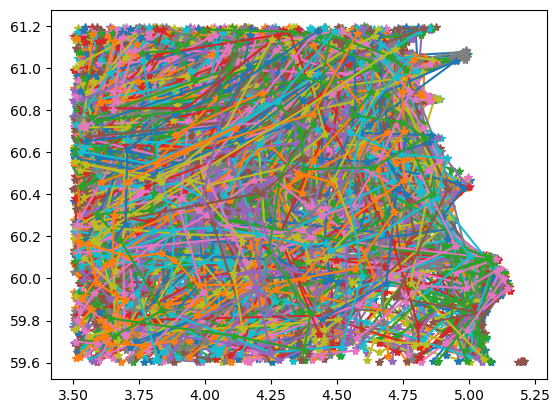

In [10]:
plt.plot(subset.longitude[:,lip],subset.latitude[:,lip],'-*'); # for all particles that entered

ID01 shape is = (365, 2303)
 3 particles are in D at the half time
 0 particles are in D at the end time
 110 particles are in D at the end time


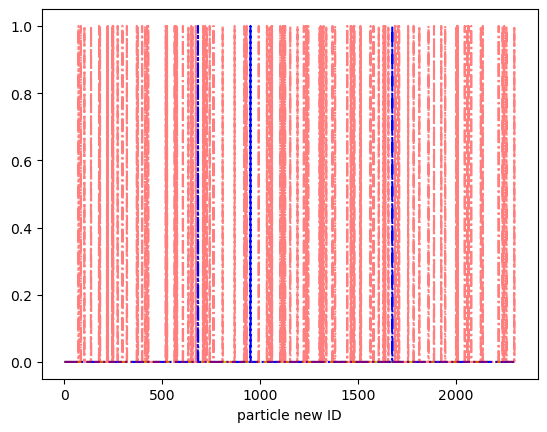

In [34]:
#create matrix of 0 and 1; each column corresponds to when the particle in D (1) and outside (0) at a time t.
ID01=~np.isnan(in_range.latitude[:,lip].values)
at_final_time=ID01[-1,:]
at_half_time= ID01[183,:]
at_special_time= ID01[13,:]
plt.plot(at_final_time,'y--')
plt.plot(at_half_time,'b-.')
plt.plot(at_special_time,'r-.',alpha = 0.5)

plt.xlabel('particle new ID')
print(f'ID01 shape is = {ID01.shape}')
print(f' {at_half_time.sum()} particles are in D at the half time')
print(f' {at_final_time.sum()} particles are in D at the end time')
print(f' {at_special_time.sum()} particles are in D at the end time')

Text(0.5, 1.0, 'for the partile new Id =100 (old Id is 1274)')

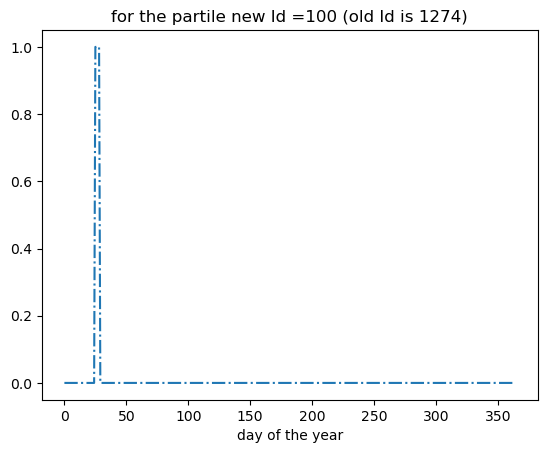

In [35]:
plt.plot(ID01[:,110],'-.')
plt.xlabel('day of the year')
plt.title(f'for the partile new Id ={100} (old Id is {lip[100]})')

In [36]:
ID01[0:5,0:7]

array([[False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False]])

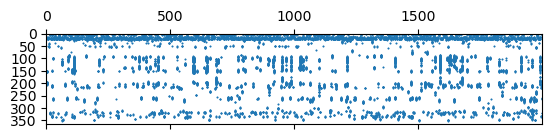

10186


In [37]:
# day of the year, and particle id. 1 if in D, 0 otherwise
M = sps.csr_matrix(ID01[:,0:2000])
plt.spy(M,markersize=0.5)
plt.show()

print(np.sum(ID01[:]))

In [38]:
inD =np.sum(ID01,axis=1)
inD

array([ 25,  98, 167, 173, 185, 145, 145,  99,  57,  10,  10,  12,  71,
       110, 336, 129,  27,  73, 228, 395, 434, 351, 428, 231,  47,  26,
        23,  20,  26,  16,  11,  19,   6,   5,   6,  13,  13,   8,   6,
        30,   9,   5,   3,   2,   3,   1,   0,   6,  10,   9,  32,  34,
        26,  13,  10,   8,   6,   6,   3,   0,   0,   0,   0,   0,   0,
         0,   1,   3,   3,   1,   1,   1,   2,   2,   3,   3,   2,   2,
         2,   2,   2,   2,   1,   0,   3,   7,  12,  12,   9,  14,  30,
        56,  58,  58,  54,  54,  52,  38,  41,  34,  31,  37,  50,  49,
        52,  52,  53,  57,  49,  49,  48,  42,  45,  38,  30,  29,  28,
        19,  24,  24,  16,  14,  12,  11,  11,  17,  19,  32,  35,  28,
        21,  22,  25,  25,  25,  38,  41,  40,  36,  38,  33,  29,  38,
        36,  37,  32,  38,  41,  46,  44,  42,  46,  53,  37,  19,  12,
        22,  11,   6,   3,   3,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   5,   7,   6,   5,   4,   3,   

In [58]:
#1 preceeded by 0
ID_entry= ID01[1:-1,:] +ID01[1:-1,:]*ID01[0:-2,:]
ID_exit= ID01[0:-2,:] + ID01[0:-2,:]* ID01[1:-1,:]

Entrylog=np.append(0,np.sum(ID_entry==1,axis =1))
Exitlog=np.append(0,np.sum(ID_exit==1,axis =1))



In [59]:
#remove the enter-and-exit situation
A =(ID_entry==1)*(ID_exit==1)
cleaned_ID_entry=ID_entry*(1-A)
cleaned_ID_exit=ID_exit*(1-A)
CleanedEntrylog=np.append(0,np.sum(cleaned_ID_entry==1,axis =1))
CleanedExitlog=np.append(0,np.sum(cleaned_ID_exit==1,axis =1))


In [65]:
Entrylog


array([  0,  98, 167, 173, 185, 145, 145,  99,  57,  10,  10,  12,  71,
       110, 336, 129,  27,  73, 228, 395, 434, 351, 428, 231,  47,  26,
        23,  20,  26,  16,  11,  19,   6,   5,   6,  13,  13,   8,   6,
        30,   9,   5,   3,   2,   3,   1,   0,   6,  10,   9,  32,  34,
        26,  13,  10,   8,   6,   6,   3,   0,   0,   0,   0,   0,   0,
         0,   1,   3,   3,   1,   1,   1,   2,   2,   3,   3,   2,   2,
         2,   2,   2,   2,   1,   0,   3,   7,  12,  12,   9,  14,  30,
        56,  58,  58,  54,  54,  52,  38,  41,  34,  31,  37,  50,  49,
        52,  52,  53,  57,  49,  49,  48,  42,  45,  38,  30,  29,  28,
        19,  24,  24,  16,  14,  12,  11,  11,  17,  19,  32,  35,  28,
        21,  22,  25,  25,  25,  38,  41,  40,  36,  38,  33,  29,  38,
        36,  37,  32,  38,  41,  46,  44,  42,  46,  53,  37,  19,  12,
        22,  11,   6,   3,   3,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   5,   7,   6,   5,   4,   3,   

In [66]:
CleanedEntrylog

array([  0,  77,  69,   8,  47,  26,  33,   3,   1,   1,   3,   3,  62,
        85, 286,  31,  20,  54, 170, 220, 126,  60,  99,  23,   4,  10,
        10,   0,  10,   1,   2,   8,   0,   0,   1,   7,   2,   0,   3,
        27,   1,   0,   2,   0,   1,   0,   0,   6,   6,   0,  26,  24,
         3,   2,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   1,   2,   1,   0,   0,   0,   1,   2,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   3,   4,   5,   2,   0,   5,  16,
        26,   2,   0,   2,  12,   1,   1,   3,   1,   1,  17,  19,   7,
         5,   0,   3,   8,   1,   1,   4,   1,   6,   4,   0,   1,   1,
         1,   5,   4,   2,   0,   0,   1,   0,   6,   2,  13,   4,   0,
         0,   1,   3,   1,   1,  14,   5,   1,   0,   4,   1,   1,  13,
         5,   2,   1,   6,   4,   7,   4,   5,   8,   8,   3,   0,   3,
        11,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   4,   2,   0,   0,   0,   0,   

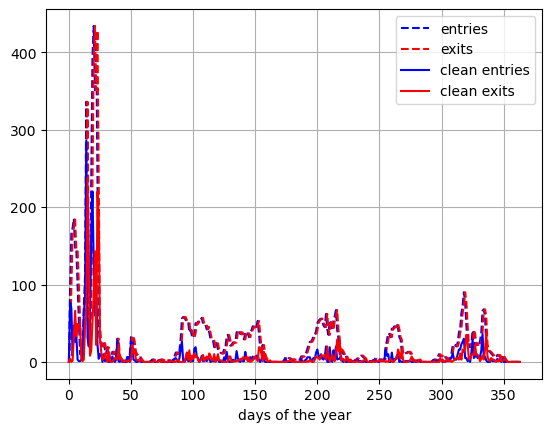

In [70]:
plt.plot(Entrylog,'b--',label ='entries')
plt.plot(Exitlog,'r--', label ='exits')
plt.plot(CleanedEntrylog,'b-',label ='clean entries')
plt.plot(CleanedExitlog,'r-', label ='clean exits')

plt.xlabel('days of the year')
plt.legend()
plt.grid()

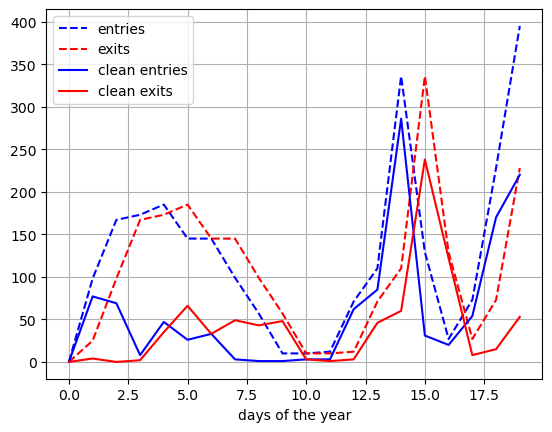

In [72]:
plt.plot(Entrylog[0:20],'b--',label ='entries')
plt.plot(Exitlog[0:20],'r--', label ='exits')
plt.plot(CleanedEntrylog[0:20],'b-',label ='clean entries')
plt.plot(CleanedExitlog[0:20],'r-', label ='clean exits')

plt.xlabel('days of the year')
plt.legend()
plt.grid()

In [69]:
print(Entrylog[15:25])
print(Exitlog[15:25])

print(CleanedEntrylog[15:25])
print(CleanedExitlog[15:25])

[129  27  73 228 395 434 351 428 231  47]
[336 129  27  73 228 395 434 351 428 231]
[ 31  20  54 170 220 126  60  99  23   4]
[238 122   8  15  53  87 143  22 220 188]


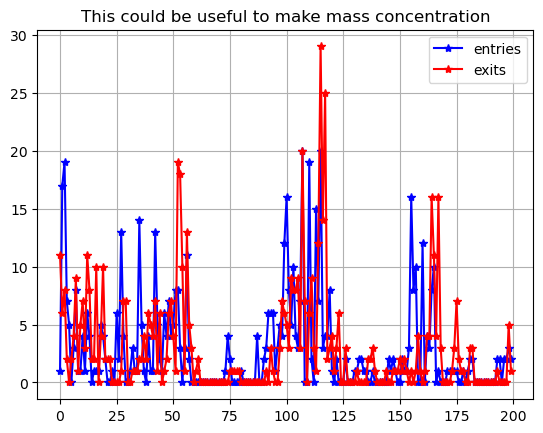

In [73]:
#Zoom in

plt.plot(CleanedEntrylog[100:300],'b-*',label = 'entries')
plt.plot(CleanedExitlog[101:301],'r-*',label = 'exits')
plt.legend()
plt.title('This could be useful to make mass concentration')
plt.grid()

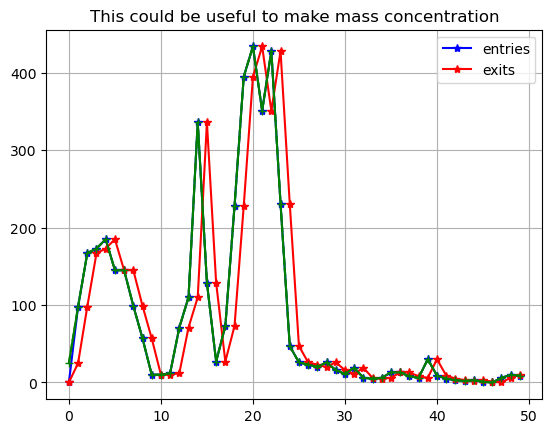

In [32]:

particles_inD = inD[0]+np.cumsum(Entrylog)-np.cumsum(Exitlog)
#particles_inD2 = np.cumsum(exits) #- np.cumsum(exits)

plt.plot(Entrylog[0:50],'b-*',label = 'entries')
plt.plot(Exitlog[0:50],'r-*',label = 'exits')
plt.plot(particles_inD[0:50],'g--')
plt.plot(inD[0:50],'g-+')

#plt.plot(particles_inD2[0:50],'r-')
plt.legend()
plt.title('This could be useful to make mass concentration')
plt.grid()


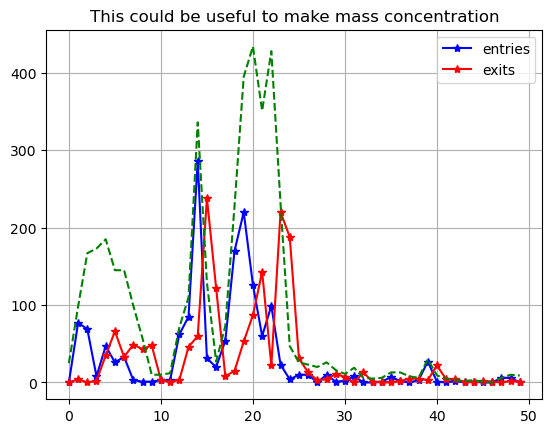

In [76]:
particles_inD = inD[0]+np.cumsum(CleanedEntrylog)-np.cumsum(CleanedExitlog)
#particles_inD2 = np.cumsum(exits) #- np.cumsum(exits)

plt.plot(CleanedEntrylog[0:50],'b-*',label = 'entries')
plt.plot(CleanedExitlog[0:50],'r-*',label = 'exits')
plt.plot(particles_inD[0:50],'g--')
#plt.plot(inD[0:50],'g-+')

#plt.plot(particles_inD2[0:50],'r-')
plt.legend()
plt.title('This could be useful to make mass concentration')
plt.grid()

In [33]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

Nt,Nn =ID01.shape


list_of_times = []
re_entry = []

for i in range(Nn):
    aux = get_indexes(1,ID01[:,i])
    re_entry.append((np.diff(aux)>1).sum())
    list_of_times.append(aux)
    if (i % 100 == 0):
        print(f'Particle with the new ID {i} has the times:')
        print(list_of_times[-1])



Particle with the new ID 0 has the times:
[]
Particle with the new ID 100 has the times:
[]
Particle with the new ID 200 has the times:
[19, 20, 21, 22]
Particle with the new ID 300 has the times:
[]
Particle with the new ID 400 has the times:
[14]
Particle with the new ID 500 has the times:
[]
Particle with the new ID 600 has the times:
[]
Particle with the new ID 700 has the times:
[]
Particle with the new ID 800 has the times:
[]
Particle with the new ID 900 has the times:
[]
Particle with the new ID 1000 has the times:
[]
Particle with the new ID 1100 has the times:
[]
Particle with the new ID 1200 has the times:
[]
Particle with the new ID 1300 has the times:
[]
Particle with the new ID 1400 has the times:
[]
Particle with the new ID 1500 has the times:
[]
Particle with the new ID 1600 has the times:
[]
Particle with the new ID 1700 has the times:
[]
Particle with the new ID 1800 has the times:
[]
Particle with the new ID 1900 has the times:
[]
Particle with the new ID 2000 has th

Particle with the new ID 17200 has the times:
[]
Particle with the new ID 17300 has the times:
[]
Particle with the new ID 17400 has the times:
[]
Particle with the new ID 17500 has the times:
[]
Particle with the new ID 17600 has the times:
[]
Particle with the new ID 17700 has the times:
[]
Particle with the new ID 17800 has the times:
[]
Particle with the new ID 17900 has the times:
[]
Particle with the new ID 18000 has the times:
[]
Particle with the new ID 18100 has the times:
[]
Particle with the new ID 18200 has the times:
[]
Particle with the new ID 18300 has the times:
[]
Particle with the new ID 18400 has the times:
[]
Particle with the new ID 18500 has the times:
[]
Particle with the new ID 18600 has the times:
[]
Particle with the new ID 18700 has the times:
[]
Particle with the new ID 18800 has the times:
[]
Particle with the new ID 18900 has the times:
[]
Particle with the new ID 19000 has the times:
[]
Particle with the new ID 19100 has the times:
[]
Particle with the ne

Particle with the new ID 34700 has the times:
[]
Particle with the new ID 34800 has the times:
[]
Particle with the new ID 34900 has the times:
[]
Particle with the new ID 35000 has the times:
[]
Particle with the new ID 35100 has the times:
[]
Particle with the new ID 35200 has the times:
[]
Particle with the new ID 35300 has the times:
[]
Particle with the new ID 35400 has the times:
[]
Particle with the new ID 35500 has the times:
[]
Particle with the new ID 35600 has the times:
[]
Particle with the new ID 35700 has the times:
[]
Particle with the new ID 35800 has the times:
[22, 23]
Particle with the new ID 35900 has the times:
[]
Particle with the new ID 36000 has the times:
[]
Particle with the new ID 36100 has the times:
[]
Particle with the new ID 36200 has the times:
[]
Particle with the new ID 36300 has the times:
[]
Particle with the new ID 36400 has the times:
[]
Particle with the new ID 36500 has the times:
[]
Particle with the new ID 36600 has the times:
[]
Particle with 

In [ ]:
re_entry_times =np.array(re_entry)

In [ ]:
plt.hist(re_entry_times);
plt.xlabel('times of re-entery')


In [ ]:
np.diff(list_of_times[1500])

In [ ]:
## DO NOT USE THIS LOOP, takes lot of time


# Initialize counters
num_particles_in_region = 0
particle_entry_counts = []

# Loop over all particles

for i in range(100):
#for i in range(len(subset.particles)):
    particle = subset.isel(particles=i)
    
    # Count the number of time steps when the particle is in the region
    num_times_in_region = particle.latitude.count().values
    
    # If the particle entered the region at least once, increment the counter
    # and store the number of times it entered the region
    if num_times_in_region > 0:
        num_particles_in_region += 1
        particle_entry_counts.append(num_times_in_region)
particle_entry_counts = np.array(particle_entry_counts)

# Calculate statistics
#mean_entries = particle_entry_counts.mean()
#min_entries = particle_entry_counts.min()
#max_entries = particle_entry_counts.max()

#print(f"Average number of entries per particle: {mean_entries}")
#print(f"Minimum number of entries for a particle: {min_entries}")
#print(f"Maximum number of entries for a particle: {max_entries}")
        
print(f"Number of particles that entered the region: {num_particles_in_region}")
print(f"Number of times each particle entered the region: {particle_entry_counts}")


In [ ]:
# Count the number of times each particle is in the region
# This should give me an array of how many times (days) the particle was within the subregion 
entry_counts = subset.latitude.count(dim='time')

# the number of particles that entered the region at least once

num_particles_in_region = (entry_counts > 0).sum().values
entry_counts_np = entry_counts.values # making it a numpy array

# Some statistics
mean_entries = entry_counts_np[entry_counts_np > 0].mean()
min_entries = entry_counts_np[entry_counts_np > 0].min()
max_entries = entry_counts_np[entry_counts_np > 0].max()

print(f"Number of particles that entered the region: {num_particles_in_region}")
print(f"Average number of entries per particle: {mean_entries}")
print(f"Minimum number of entries for a particle: {min_entries}")
print(f"Maximum number of entries for a particle: {max_entries}")

In [ ]:
print(entry_counts_np[entry_counts_np > 0])

In [ ]:

minlon, maxlon, minlat, maxlat = (lon_range[0],lon_range[1], lat_range[0],lat_range[1])


proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 6))
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
main_ax.coastlines()
plt.scatter(in_range.isel(time=99).longitude.compute(),in_range.isel(time=99).latitude.compute(),color='red')
plt.scatter(in_range.isel(time=100).longitude.compute(),in_range.isel(time=100).latitude.compute(),color='blue')




#plt.scatter(in_range.longitude.compute(),in_range.latitude.compute(),s=0.08)
#main_ax.set_title("particle locations")
main_ax.set_title("Time = " + str(in_range.coords['time'].values[0])[:10])


Making an attempt to loop over all files for a single country
   

In [ ]:
import glob
import os
# This is for a single country; change the name of the country if you wish to extract for some other country

# The directory and file pattern
directory = r'C:\Users\prith\Downloads\Simulations\ocean_leeway\Belgium'
file_pattern = '**/output/pylag_1.nc'

# Geting a list of all files with this pattern
files = glob.glob(os.path.join(directory, file_pattern), recursive=True)

len(files)

In [ ]:
files



In [ ]:
# For one single file, testing this,select a random file
# It takes the in_range from previously run data

#lon_range = (3.5,6)  # Longitude range
#lat_range = (59.6,61.2)  # latitude range

dataset = xr.open_dataset(files[15])
dataset = dataset.sel(time=slice('2020-01-01', '2020-12-31'))
in_range = dataset.where((dataset.latitude >= lat_range[0]) & (dataset.latitude <= lat_range[1]) & 
                                   (dataset.longitude >= lon_range[0]) & (dataset.longitude <= lon_range[1]))

subset = in_range[['latitude', 'longitude']]
entry_counts = subset.latitude.count(dim='time')
num_particles_in_region = (entry_counts > 0).sum().values
entry_counts_np = entry_counts.values


num_particles_in_region = ((~np.isnan(in_range.latitude)).sum(dim='time') > 0).sum().values
mean_entries = entry_counts_np[entry_counts_np > 0].mean()
min_entries = entry_counts_np[entry_counts_np > 0].min()
max_entries = entry_counts_np[entry_counts_np > 0].max()

In [ ]:
entry_counts

In [ ]:
num_particles_in_region

In [ ]:
# This should print everything for me

# Loop over all the files
for file in files:
    # Extract start year and month from the file path
    start_month = os.path.basename(os.path.dirname(os.path.dirname(file)))
    start_year = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(file))))

    # Opening the file with xarray
    dataset = xr.open_dataset(file)
    
    # Selecting the data for the year 2020 only
    dataset_2020 = dataset.sel(time=slice('2020-01-01', '2020-12-31'))

    
    # Extract the sub region of our interest
    in_range = dataset_2020.where((dataset_2020.latitude >= lat_range[0]) & (dataset_2020.latitude <= lat_range[1]) & 
                                   (dataset_2020.longitude >= lon_range[0]) & (dataset_2020.longitude <= lon_range[1]))

    # Subset the dataset
    subset = in_range[['latitude', 'longitude']]
    
    # Count the number of times each particle is in the region
    # This gives an array (of length = number of particles) of how many times each particle has entered the region
    entry_counts = subset.latitude.count(dim='time')
    
    # This gives the number of particles that entered the region at least once
    num_particles_in_region = (entry_counts > 0).sum().values

    # Converting the entry_counts DataArray to a numpy array for easier calculations
    entry_counts_np = entry_counts.values

    # Calculating some statistics
    mean_entries = entry_counts_np[entry_counts_np >= 0].mean()
    min_entries = entry_counts_np[entry_counts_np >= 0].min()
    max_entries = entry_counts_np[entry_counts_np >= 0].max()

    # Printing part
    print("")
    #print(f"File: {file}")
    print(f"Start year: {start_year}, Start month: {start_month}")
    print(f"Number of particles that entered the region: {num_particles_in_region}")
    print(f"Average number of entries per particle: {mean_entries}")
    print(f"Minimum number of entries for a particle: {min_entries}")
    print(f"Maximum number of entries for a particle: {max_entries}")


In [ ]:
# This is a test for creating the Pandas dataframe above for 1 single file.
# Tested with Belgium, above is UK
file = r'C:\Users\prith\Downloads\Simulations\ocean_leeway\Belgium\2018\12\output\pylag_1.nc'
sim = xr.open_dataset(file)
sim = sim.sel(time=slice('2020-01-01', '2020-12-31'))  # Select only 2020
in_range =  sim.where(sim.latitude > lat_range[0]).where(sim.latitude < lat_range[1]).where(sim.longitude > lon_range[0]).where(sim.longitude < lon_range[1])
num_particles_in_region = ((~np.isnan(in_range.latitude)).sum(dim='time') > 0).sum().values


if num_particles_in_region > 0:  # Only calculate these if there are particles in the region
    num_entries_per_particle = (~np.isnan(in_range.latitude)).sum(dim='time').values
    mean_entries = num_entries_per_particle.mean()
    min_entries = num_entries_per_particle.min()
    max_entries = num_entries_per_particle.max()
else:  # If no particles in the region, these are all zero
    mean_entries = 0
    min_entries = 0
    max_entries = 0

In [ ]:
#num_entries_per_particle.sum()
#((~np.isnan(in_range.latitude)).sum(dim='time') > 0).sum()
(~np.isnan(in_range.latitude)).sum(dim='time').values

In [ ]:
print('Mean entries with zeros',(~np.isnan(in_range.latitude)).sum(dim='time').values.mean())
print('Mean entries without zeros',(~np.isnan(in_range.latitude)).sum(dim='time').values[(~np.isnan(in_range.latitude)).sum(dim='time').values>0].mean())

(~np.isnan(in_range.latitude)).sum(dim='time').values[(~np.isnan(in_range.latitude)).sum(dim='time').values>0]


In [ ]:
import pandas as pd
from datetime import datetime
# Create an empty list to hold the data
data = []
# Check name of country
# Loop through files
for start_year in range(2017, 2021):
    for start_month in range(1, 13):
        #file = 'C:\Users\prith\Downloads\Simulations\ocean_leeway\UK\' + {start_year} + 'output\pylag_1.nc'
        file = fr'C:\Users\prith\Downloads\Simulations\ocean_leeway\Belgium\{start_year}\{start_month:02}\output\pylag_1.nc'

        print(start_year,start_month)
        if os.path.exists(file):
            sim = xr.open_dataset(file)
            sim = sim.sel(time=slice('2020-01-01', '2020-12-31'))  # Select only 2020
            in_range =  sim.where(sim.latitude > lat_range[0]).where(sim.latitude < lat_range[1]).where(sim.longitude > lon_range[0]).where(sim.longitude < lon_range[1])
            num_particles_in_region = ((~np.isnan(in_range.latitude)).sum(dim='time') > 0).sum().values
            
            # Sometimes we do not find particles in the region at all, for a specific file(country/month),
            # so the If condition is necessary in the next line
            
            if num_particles_in_region > 0:  # Only calculate these if there are particles in the region
                num_entries_per_particle = (~np.isnan(in_range.latitude)).sum(dim='time').values
                mean_entries = num_entries_per_particle.mean()
                min_entries = num_entries_per_particle.min()
                max_entries = num_entries_per_particle.max()
            else:  # If no particles in the region, these are all zero
                mean_entries = 0
                min_entries = 0
                max_entries = 0
                
            # Append the data for this file to the list
            data.append({
                'Start Year': start_year,
                'Start Month': start_month,
                'time': datetime(start_year, start_month, 1), 
                'Country' : file[50:-26],
                'Num Particles in Region': num_particles_in_region,
                'Mean Entries': mean_entries,
                'Min Entries': min_entries,
                'Max Entries': max_entries
            })

# Convert the list into a DataFrame
df = pd.DataFrame(data)

# Now you can print or save the DataFrame, or perform further analysis
#print(df)


In [ ]:
df

In [ ]:
np.where(num_entries_per_particle==12)
#np.where(num_entries_per_particle==139)


In [ ]:
#in_range.isel(particles=slice(441,442)).plot.line(x='longitude',y='latitude')

minlon, maxlon, minlat, maxlat = (lon_range[0]-1,lon_range[1]+1, lat_range[0]-1,lat_range[1]+1)


proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 6))
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
main_ax.coastlines()



plt.plot(sim.isel(particles=276).longitude,sim.isel(particles=276).latitude,color='gray')
plt.plot(in_range.isel(particles=274).longitude,in_range.isel(particles=441).latitude,color='orange')
plt.scatter(in_range.isel(particles=274).longitude[0],in_range.isel(particles=441).latitude[0],color='red')


In [ ]:
in_range

In [ ]:
in_range.isel(particles=441).longitude.plot()

In [ ]:
df

In [ ]:
num_entries_per_particle
#data

In [ ]:
subset.groupby("particles")

In [ ]:
k=103
#for k in range(102,104):
in_region = ~(subset.isel(particles = k).latitude.isnull() | subset.isel(particles = k).longitude.isnull())
in_region
#plt.show()

In [ ]:
in_region.astype(int)


In [ ]:
in_region.astype(int).diff(dim='time')
# if a particle moves into the region, the difference would be 1
# If a particle stays in the region or stays out of the region, the difference would be 0 (state doesn't change)
# If a particle moves out of the region, the difference would be -1.

In [ ]:
(in_region.astype(int).diff(dim='time') == 1).sum()
# This will give me the number of 1s and give me an idea about re-entries

In [ ]:
subset

In [ ]:
def get_reentries(particle_data):
    # Determine whether the particle is in the region at each time step
    in_region = ~(particle_data.latitude.isnull() | particle_data.longitude.isnull())

    # Calculating re-entries
    # Subtract the shifted series from the original series we do this by taking a derivative
    # Entries of 1 in the resulting series correspond to re-entries
    reentries = in_region.astype(int).diff(dim="time")
    
    # Count the number of re-entries
    num_reentries = (reentries == 1).sum()

    return num_reentries

# Use groupby to process each particle separately
num_reentries_per_particle = subset.groupby("particles").apply(get_reentries)

# Convert the result to a pandas DataFrame
reentry_data = num_reentries_per_particle.to_dataframe(name="Number of Reentries").reset_index()

In [ ]:
#reentry_data.num_reentries_per_particle.plot.hist()
reentry_data

In [ ]:
# Don't use this, there's a small error

import pandas as pd
import os
import xarray as xr


# Define the function to calculate re-entries
def get_reentries(particle_data):
    # Using Or operator to see if particle is in the box or not
    in_region = ~(particle_data.latitude.isnull() | particle_data.longitude.isnull())
    reentries = in_region.astype(int).diff(dim="time")
    num_reentries = (reentries == 1).sum(dim="time")
    return num_reentries

results = []
# DataFrame to store the results
#results = pd.DataFrame(columns=["Start Year", "Start Month", "Time","Country" ,"Number of Particles in Region", 
#                                "Average Entries Per Particle", "Minimum Entries", "Maximum Entries", 
#                                "Average Reentries Per Particle", "Minimum Reentries", "Maximum Reentries"])

# Loop through the folders
for start_year in range(2017, 2021):
    for start_month in range(1, 13):
        file = fr'C:\Users\prith\Downloads\Simulations\ocean_leeway\Belgium\{start_year}\{start_month:02}\output\pylag_1.nc'
        print(start_year,start_month)
        # Check if the file exists
        if os.path.exists(file):
            ds = xr.open_dataset(file)

            # Select the data for 2020
            ds_2020 = ds.sel(time=slice('2020-01-01', '2020-12-31'))

            # Get the data within the region of interest
            lon_range = (3.5,6)  
            lat_range = (59.6,61.2) 
            subset = ds_2020.where((ds_2020.latitude > lat_range[0]) & (ds_2020.latitude < lat_range[1]) 
                                   & (ds_2020.longitude > lon_range[0]) & (ds_2020.longitude < lon_range[1]))

            #num_particles_in_region = subset['particles'].count(dim='time').compute()             
   
            num_particles_in_region = ((~np.isnan(subset.latitude)).sum(dim='time') > 0).sum().values
            
            if num_particles_in_region > 0:  # Only calculate these if there are particles in the region
                num_entries_per_particle = (~np.isnan(subset.latitude)).sum(dim='time').values
                mean_entries = num_entries_per_particle.mean()
                min_entries = num_entries_per_particle.min()
                max_entries = num_entries_per_particle.max()
            else:  # If no particles in the region, these are all zero
                mean_entries = 0
                min_entries = 0
                max_entries = 0
            

            #num_entries_per_particle = (~subset.latitude.isnull() & ~subset.longitude.isnull()).sum(dim='time').compute()
            
            num_reentries_per_particle = subset.groupby("particles").apply(get_reentries).compute().values

            #num_reentries_per_particle = np.array(num_reentries_per_particle)

            
            # Append the data for this file to the list
            results.append({
                #"Start Year": start_year,
                #"Start Month": start_month,
                'time': datetime(start_year, start_month, 1),
                'Country' : file[50:-26],
                "Number of Particles in Region": num_particles_in_region,
                "Average Entries Per Particle": mean_entries,
                "Minimum Entries": min_entries,
                "Maximum Entries": max_entries,
                "Average Reentries Per Particle": num_reentries_per_particle.mean(),
                "Minimum Reentries": num_reentries_per_particle.min(),
                "Maximum Reentries": num_reentries_per_particle.max()
            })
df1 = pd.DataFrame(results)
            
#df1.to_csv("results_UK.csv", index=False)


In [ ]:
import pandas as pd
import os
import xarray as xr


# Define the function to calculate re-entries
def get_reentries(particle_data):
    # Using Or operator to see if particle is in the box or not
    in_region = ~(particle_data.latitude.isnull() | particle_data.longitude.isnull())
    reentries = in_region.astype(int).diff(dim="time")
    num_reentries = (reentries == 1).sum(dim="time")
    return num_reentries

results = []
# DataFrame to store the results
#results = pd.DataFrame(columns=["Start Year", "Start Month", "Time","Country" ,"Number of Particles in Region", 
#                                "Average Entries Per Particle", "Minimum Entries", "Maximum Entries", 
#                                "Average Reentries Per Particle", "Minimum Reentries", "Maximum Reentries"])

# Loop through the folders
for start_year in range(2017, 2021):
    for start_month in range(1, 13):
        file = fr'C:\Users\prith\Downloads\Simulations\ocean_leeway\Belgium\{start_year}\{start_month:02}\output\pylag_1.nc'
        print(start_year,start_month)
        # Check if the file exists
        if os.path.exists(file):
            ds = xr.open_dataset(file)

            # Select the data for 2020
            ds_2020 = ds.sel(time=slice('2020-01-01', '2020-12-31'))

            # Get the data within the region of interest
            lon_range = (3.5,6)  
            lat_range = (59.6,61.2) 
            subset = ds_2020.where((ds_2020.latitude > lat_range[0]) & (ds_2020.latitude < lat_range[1]) 
                                   & (ds_2020.longitude > lon_range[0]) & (ds_2020.longitude < lon_range[1]))

            #num_particles_in_region = subset['particles'].count(dim='time').compute()             
   
            num_particles_in_region = ((~np.isnan(subset.latitude)).sum(dim='time') > 0).sum().values
            
            if num_particles_in_region > 0:  # Only calculate these if there are particles in the region
                num_entries_per_particle = (~np.isnan(subset.latitude)).sum(dim='time').values
                mean_entries = num_entries_per_particle.mean()
                min_entries = num_entries_per_particle.min()
                max_entries = num_entries_per_particle.max()
            else:  # If no particles in the region, these are all zero
                mean_entries = 0
                min_entries = 0
                max_entries = 0
            

            #num_entries_per_particle = (~subset.latitude.isnull() & ~subset.longitude.isnull()).sum(dim='time').compute()
            
            num_reentries_per_particle = subset.groupby("particles").apply(get_reentries).compute().values

            #num_reentries_per_particle = np.array(num_reentries_per_particle)

            if len(num_reentries_per_particle[num_reentries_per_particle>0])==0:
                reentries_mean = 0;
                reentries_min = 0;
                reentries_max = 0;    
            else:
                reentries_mean = num_reentries_per_particle[num_reentries_per_particle>0].mean();
                reentries_min = num_reentries_per_particle[num_reentries_per_particle>0].min();
                reentries_max = num_reentries_per_particle[num_reentries_per_particle>0].max();
            # Append the data for this file to the list
            results.append({
                #"Start Year": start_year,
                #"Start Month": start_month,
                'time': datetime(start_year, start_month, 1),
                'Country' : file[50:-26],
                "Number of Particles in Region": num_particles_in_region,
                "Average Entries Per Particle": mean_entries,
                "Minimum Entries": min_entries,
                "Maximum Entries": max_entries,
                "Average Reentries Per Particle": reentries_mean,
                "Minimum Reentries": reentries_min,
                "Maximum Reentries": reentries_max
            })
df1 = pd.DataFrame(results)
            
#df1.to_csv("results_UK.csv", index=False)


In [ ]:
len(num_reentries_per_particle[num_reentries_per_particle>0])

In [ ]:
df1.to_csv("results_Belgium_new.csv", index=False)
df1

In [ ]:
#df['Mean Entries'].plot.line(color = 'red')
plt.figure(figsize=(12, 4))
plt.plot(df['time'],df['Mean Entries'],label='Mean Entries')
plt.plot(df['time'],df['Max Entries'],label='Max number of Entries')
plt.plot(df['time'],df['Min Entries'],label='Minimum number of Entries')

#df.plot.line(x='time',y='Mean Entries')
plt.legend()
plt.show()
#df['Min Entries'].plot.line()


In [ ]:
import seaborn as sns
pivot_table = df.pivot_table(values='Num Particles in Region', index='Start Month', columns='Start Year')
sns.heatmap(pivot_table)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'subset' is your data with lat, lon
latitudes = subset.latitude.values.flatten()
longitudes = subset.longitude.values.flatten()

# Remove NaN values
valid_indices = ~np.isnan(latitudes) & ~np.isnan(longitudes)
latitudes = latitudes[valid_indices]
longitudes = longitudes[valid_indices]

#plt.hist2d(longitudes, latitudes, bins=[100, 100], cmap='hot')
plt.scatter(longitudes, latitudes, color='blue',s=0.1)
#plt.colorbar(label='Count')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of particle locations')
plt.show()


In [ ]:
dataset = xr.open_dataset(files[47])
dataset = dataset.sel(time=slice('2020-01-01', '2020-12-31'))

dataset.plot.scatter(x='longitude',y='latitude')

In [ ]:
# Create a new matplotlib figure and set its size
fig = plt.figure(figsize=(12, 6))
minlon, maxlon, minlat, maxlat = (dataset.longitude.min(),dataset.longitude.max(), dataset.latitude.min(),dataset.latitude.max())

# Create a Cartopy PlateCarree projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.COASTLINE)


# Plot the particles
scat = ax.scatter(dataset.longitude, dataset.latitude, color='blue', transform=ccrs.PlateCarree(),s=5)
ax.plot(dataset.isel(particles=0).longitude, dataset.isel(particles=0).latitude, color='red', transform=ccrs.PlateCarree())

plt.show()


In [ ]:

# Assuming 'subset' is your data with lat, lon
latitudes = subset.latitude.values
longitudes = subset.longitude.values

# Create a new matplotlib figure and set its size
fig = plt.figure(figsize=(12, 6))
minlon, maxlon, minlat, maxlat = (lon_range[0],lon_range[1], lat_range[0],lat_range[1])

# Create a Cartopy PlateCarree projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.COASTLINE)


# Plot the particles
scat = ax.scatter(longitudes, latitudes, color='blue', transform=ccrs.PlateCarree())
plt.show()


In [ ]:
subset['particles'].nunique.compute()